In [1]:
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import numpy as np
from pyro.infer.autoguide import AutoDiagonalNormal,AutoIAFNormal,AutoNormal,AutoLowRankMultivariateNormal,AutoDelta,AutoContinuous,AutoMultivariateNormal,AutoNormalizingFlow,AutoLaplaceApproximation
import time
import statistics
import seaborn as sns
from pyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt

In [2]:
def plot(x):
    fig = plt.figure(figsize=(6, 2))
    sns.distplot(x, hist = False, kde = True,
                kde_kws = {'shade': True, 'linewidth': 1}, color = 'c')
    plt.axvline(x = statistics.median(x))
    print(statistics.median(x))
    plt.xlim(0,3)

In [16]:
# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
n_steps = 2 if smoke_test else 2000

assert pyro.__version__.startswith('1.6.0')

# clear the param store in case we're in a REPL
pyro.clear_param_store()

In [3]:
# create some data with 6 observed heads and 4 observed tails
%timeit
data = []
with open("STANINPUTS/2_data_1.0_1000_read300.txt","rt") as IN:
        for line in IN:
            fields=line.rstrip().split()
            fields = [float(i) for i in fields]
            fields = [torch.tensor(i) for i in fields]
            data.append(fields[5:7] + fields[8:28])

In [4]:
#single site
def model(data):
    c1 = pyro.sample("c1", dist.Gamma(torch.tensor(1.1), 
                                      torch.tensor(0.005)))
    c2 = pyro.sample("c2", dist.Gamma(torch.tensor(1.1), 
                                      torch.tensor(0.005)))
    s  = pyro.sample("s", dist.Gamma(torch.tensor(1.618),
                                    torch.tensor(2.618)))
    
    theta = pyro.sample("theta",dist.LogNormal(torch.tensor(0.0),s))
    p = pyro.sample("p", dist.Beta(torch.tensor(0.1)*(c1-2)+1,
                                       (torch.tensor(1)-torch.tensor(0.1))*(c1-1) + 1))
    q = (theta*p)/(1-p+theta*p)

    pyro.sample("DNA", dist.Binomial(data[0]+data[1],p), obs=data[0])
    
    for i in np.linspace(2,10,5):
        exec("qi_{} = pyro.sample('qi_{}', dist.Beta(q*(c2-2)+1, (1-q)*(c2-1)+1))".format(int(i/2),int(i/2)))
        exec( "pyro.sample('RNA_{}', dist.Binomial(data[int(i)] + data[int(i+1)],qi_{}), obs=data[int(i)])".format(int(i/2),int(i/2)))        
        

In [4]:
# multiple site
def model(data):
    c1 = pyro.sample("c1", dist.Gamma(torch.tensor(1.1), 
                                      torch.tensor(0.005)))
    c2 = pyro.sample("c2", dist.Gamma(torch.tensor(1.1), 
                                      torch.tensor(0.005)))
    s  = pyro.sample("s", dist.Gamma(torch.tensor(1.618),
                                    torch.tensor(2.618)))
    for i in range(len(data)):
        exec("theta_{} = pyro.sample('theta_{}',dist.LogNormal(torch.tensor(0.0),s))".format(i,i) )
        exec("p_{} = pyro.sample('p_{}', dist.Beta(torch.tensor(0.1)*(c1-2)+1,(torch.tensor(1)-torch.tensor(0.1))*(c1-1) + 1))".format(i,i))
        exec("q_{} = (theta_{}*p_{})/(1-p_{}+theta_{}*p_{})".format(i,i,i,i,i,i))
        exec("pyro.sample('DNA_{}', dist.Binomial(data[i][0]+data[i][1],p_{}), obs=data[i][1])".format(i,i))
        for j in np.linspace(2,20,10):
            exec("qi_{}_{} = pyro.sample('qi_{}_{}', dist.Beta(q_{}*(c2-2)+1, (1-q_{})*(c2-1)+1))".format(i,int(j/2),i,int(j/2),i,i))
            exec( "pyro.sample('RNA_{}_{}', dist.Binomial(data[i][int(j)] + data[i][int(j+1)],qi_{}_{}), obs=data[i][int(j+1)])".format(i,int(j/2),i,int(j/2))) 
            
            

        

In [7]:
'''
def guide(data):
    c1_1 = pyro.param('c1_1', torch.tensor(10.), constraint=constraints.positive)
    c1_2 = pyro.param('c1_2', torch.tensor(10.), constraint=constraints.positive)
    c2_1 = pyro.param('c2_1', torch.tensor(10.), constraint=constraints.positive)
    c2_2 = pyro.param('c2_2', torch.tensor(10.), constraint=constraints.positive)
    s_1 = pyro.param('s_1', torch.tensor(10.), constraint=constraints.positive)
    s_2 = pyro.param('s_2', torch.tensor(10.), constraint=constraints.positive)
    c1 = pyro.sample("c1", dist.Gamma(c1_1, 
                                      c1_2))
    c2 = pyro.sample("c2", dist.Gamma(c2_1, 
                                      c2_2))
    s  = pyro.sample("s", dist.Gamma(s_1,
                                    s_2))
    for i in range(len(data)):
        exec("theta_{} = pyro.sample('theta_{}',dist.LogNormal(torch.tensor(0.0),s))".format(i,i) )
        exec("p_{} = pyro.sample('p_{}', dist.Beta(torch.tensor(0.1)*(c1-2)+1,(torch.tensor(1)-torch.tensor(0.1))*(c1-1) + 1))".format(i,i))
        exec("q_{} = (theta_{}*p_{})/(1-p_{}+theta_{}*p_{})".format(i,i,i,i,i,i))
        for j in np.linspace(2,20,10):
            exec("qi_{}_{} = pyro.sample('qi_{}_{}', dist.Beta(q_{}*(c2-2)+1, (1-q_{})*(c2-1)+1))".format(i,int(j/2),i,int(j/2),i,i))
'''        

#AutoGuideList?
#Own Guide?
ADN_guide = AutoDiagonalNormal(model) 
AN_guide = AutoNormal(model)
AD_guide = AutoDelta(model)
ALRMN_guide = AutoLowRankMultivariateNormal(model)
ALA_guide = AutoLaplaceApproximation(model)
# guide = ALA_guide.laplace_approximation()

In [174]:
# ADN_guide
# setup the optimizer
start = time.time()
pyro.clear_param_store()
adam_params = {"lr": 0.05}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, ADN_guide, optimizer, loss=Trace_ELBO())

# do gradient steps

num_iterations = 400
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

# grab the learned variational parameters
#theta_x = pyro.param("theta_x").item()

end = time.time()

print(end - start)

[iteration 0001] loss: 51.3629
[iteration 0101] loss: 29.7089
[iteration 0201] loss: 29.8239
[iteration 0301] loss: 29.8206
7098.994339942932


1.4864798784255981
0.11197520047426224
0.18607151359319687


/Users/sean00002/anaconda3/envs/tensorflow/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/sean00002/anaconda3/envs/tensorflow/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/sean00002/anaconda3/envs/tensorflow/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code

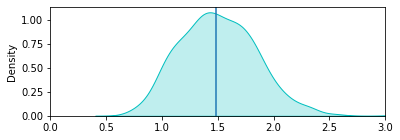

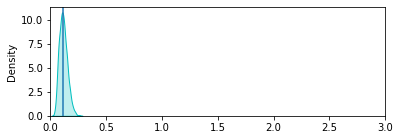

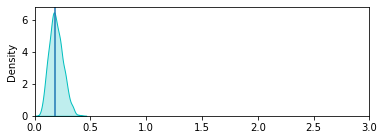

In [242]:
ADN_guide


thetas_ADN = sum([val for key, val in ADN_guide.quantiles([0.5]).items() if 'theta' in key],[])
thetas_ADN = [float(i) for i in thetas_ADN]

p_ADN = sum([val for key, val in ADN_guide.quantiles([0.5]).items() if 'p' in key],[])
p_ADN = [float(i) for i in p_ADN]

qi_ADN = [val for key, val in ADN_guide.quantiles([0.5]).items() if 'qi' in key]
qi_ADN = sum(qi_ADN, [])
qi_ADN = [float(i) for i in qi_ADN]
qi_ADN = np.reshape(qi_ADN, (1002,10))
qi_ADN = np.mean(qi_ADN, axis =-1)

ADN_results = ADN_guide.quantiles([0.5])

plot(thetas_ADN)
plot(p_ADN)
plot(qi_ADN)

In [175]:
#AN_guide
# setup the optimizer
start = time.time()
pyro.clear_param_store()
adam_params = {"lr": 0.05}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, AN_guide, optimizer, loss=Trace_ELBO())

# do gradient steps

num_iterations = 400
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

# grab the learned variational parameters
#theta_x = pyro.param("theta_x").item()

end = time.time()

print(end - start)

[iteration 0001] loss: 221.5240
[iteration 0101] loss: 29.9481
[iteration 0201] loss: 29.8170
[iteration 0301] loss: 29.7685
10362.952114105225


1.4897940754890442
0.11206769943237305
0.18607401438057422


/Users/sean00002/anaconda3/envs/tensorflow/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/sean00002/anaconda3/envs/tensorflow/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/sean00002/anaconda3/envs/tensorflow/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code

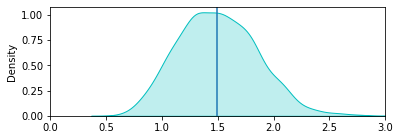

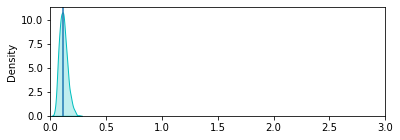

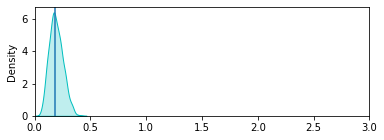

In [241]:
AN_guide

thetas_AN = [val for key, val in AN_guide.quantiles([0.5]).items() if 'theta' in key]
thetas_AN = [float(i) for i in thetas_AN]

p_AN = [val for key, val in AN_guide.quantiles([0.5]).items() if 'p' in key]
p_AN = [float(i) for i in p_AN]

qi_AN = [val for key, val in AN_guide.quantiles([0.5]).items() if 'qi' in key]
qi_AN = [float(i) for i in qi_AN]
qi_AN = np.reshape(qi_AN, (1002,10))
qi_AN = np.mean(qi_AN, axis=-1)

AN_results = AN_guide.quantiles([0.5])

plot(thetas_AN)
plot(p_AN)
plot(qi_AN)


In [8]:
#AD_guide
# setup the optimizer
start = time.time()
pyro.clear_param_store()
adam_params = {"lr": 0.05}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, AD_guide, optimizer, loss=Trace_ELBO())

# do gradient steps

num_iterations = 1500
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

# grab the learned variational parameters
#theta_x = pyro.param("theta_x").item()

end = time.time()

print(end - start)

[iteration 0001] loss: 14.9638
[iteration 0101] loss: -23.5329
[iteration 0201] loss: -27.2803
[iteration 0301] loss: -31.5559
[iteration 0401] loss: -33.0330
[iteration 0501] loss: -27.2198
[iteration 0601] loss: -30.8866
[iteration 0701] loss: -30.4044
[iteration 0801] loss: -32.5697
[iteration 0901] loss: -34.2160
[iteration 1001] loss: 7.1781
[iteration 1101] loss: 5.1056
[iteration 1201] loss: -20.9444
[iteration 1301] loss: -34.2529
[iteration 1401] loss: -33.5350
25866.95954990387


In [5]:
AD_guide

thetas_AD = [val for key, val in AD_guide.median().items() if 'theta' in key]
thetas_AD = [float(i) for i in thetas_AD]

p_AD = [val for key, val in AD_guide.median().items() if 'p' in key]
p_AD = [float(i) for i in p_AD]

qi_AD = [val for key, val in AD_guide.median().items() if 'qi' in key]
qi_AD = [float(i) for i in qi_AD]
qi_AD = np.reshape(qi_AD, (1002,10))
qi_AD = np.mean(qi_AD, axis=-1)

AD_results = AD_guide.median()

plot(thetas_AD)
plot(p_AD)
plot(qi_AD)

NameError: name 'AD_guide' is not defined

In [178]:
# ALRMN_guide
# setup the optimizer
start = time.time()
pyro.clear_param_store()
adam_params = {"lr": 0.05}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, ALRMN_guide, optimizer, loss=Trace_ELBO())

# do gradient steps

num_iterations = 400
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

# grab the learned variational parameters
#theta_x = pyro.param("theta_x").item()

end = time.time()

print(end - start)

[iteration 0001] loss: 56.2671
[iteration 0101] loss: 43.6315
[iteration 0201] loss: 41.1468
[iteration 0301] loss: 44.1968
7149.365198135376


1.2825602293014526
0.1143387034535408
0.18255890905857086


/Users/sean00002/anaconda3/envs/tensorflow/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/sean00002/anaconda3/envs/tensorflow/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/sean00002/anaconda3/envs/tensorflow/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code

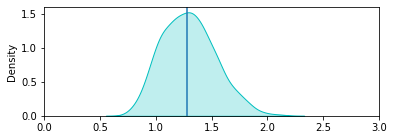

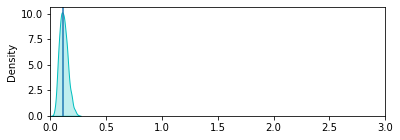

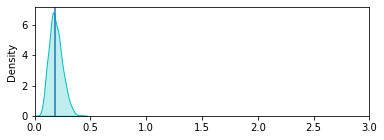

In [240]:
ALRMN_guide

thetas_ALRMN = [val for key, val in ALRMN_guide.median().items() if 'theta' in key]
thetas_ALRMN = [float(i) for i in thetas_ALRMN]

p_ALRMN = [val for key, val in ALRMN_guide.median().items() if 'p' in key]
p_ALRMN = [float(i) for i in p_ALRMN]

qi_ALRMN = [val for key, val in ALRMN_guide.median().items() if 'qi' in key]
qi_ALRMN = [float(i) for i in qi_ALRMN]
qi_ALRMN = np.reshape(qi_ALRMN, (1002,10))
qi_ALRMN = np.mean(qi_ALRMN, axis=-1)

ALRMN_results = ALRMN_guide.median()

plot(thetas_ALRMN)
plot(p_ALRMN)
plot(qi_ALRMN)



# qi to q model 

In [9]:
# qi to q model 
def model_q (data):
    c2 = pyro.sample("c2", dist.Gamma(torch.tensor(0.005), torch.tensor(1.1)))
    for i in range(len(data)):
        exec("q_{}  = pyro.sample('q_{}', dist.Uniform(torch.tensor(0.0), torch.tensor(1.0)))".format(i,i))
        for j in range(1,11):
            exec("pyro.sample('q_{}_{}', dist.Beta(q_{}*(c2-2)+1, (1-q_{})*(c2-1)+1), obs=data[i][j-1])".format(i,j,i,i))
            
# qi data
data = [val for key, val in AN_guide.median().items() if 'qi' in key]
data = [float(i) for i in data]
data = [torch.tensor(i) for i in data]
data = np.reshape(data, (1002,10))
data = torch.tensor(data)

# guide
AD_guide_q = AutoDelta(model_q) 

AttributeError: 'NoneType' object has no attribute 'iter_stochastic_nodes'

In [290]:
#AN_guide
# setup the optimizer
start = time.time()
pyro.clear_param_store()
adam_params = {"lr": 0.05}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model_q, AD_guide_q, optimizer, loss=Trace_ELBO())

# do gradient steps

num_iterations = 200
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

# grab the learned variational parameters
#theta_x = pyro.param("theta_x").item()

end = time.time()

print(end - start)

ValueError: The parameter concentration has invalid values
Trace Shapes:  
 Param Sites:  
Sample Sites:  
      c2 dist |
        value |
     q_0 dist |
        value |
Trace Shapes:
 Param Sites:
Sample Sites:

0.17725984007120132


/Users/sean00002/anaconda3/envs/tensorflow/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


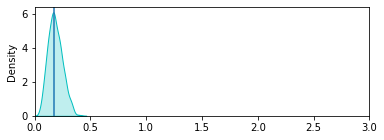

In [288]:
x = [val for key, val in AN_guide_q.median().items() if 'q' in key]
x = [float(i) for i in x]
plot(x)

In [ ]:
# q, p to theta model 
def model_theta(data):
    s  = pyro.sample("s", dist.Gamma(torch.tensor(1.618),
                                    torch.tensor(2.618)))
    for i in range(len(data)):
        exec("theta_{} = pyro.sample('theta_{}',dist.LogNormal(torch.tensor(0.0),s))".format(i,i) )
        
        
# data 
np.array(p_ADN)
        